# Polar H10 ECG-datastream
9.2.2022, Sakari Lukkarinen<br>
Metropolia University of Applied Sciences<br>


- [Github - Polar H10 ECG Stream - Python example by Pareek Nikhil](https://github.com/pareeknikhil/biofeedback/tree/master/Polar%20Device%20Data%20Stream/ECG)
- [Creating a data stream with polar device - Blog post by Pareek Nikhil](https://towardsdatascience.com/creating-a-data-stream-with-polar-device-a5c93c9ccc59)
- [Bleak documentation](https://bleak.readthedocs.io/en/latest)
- [Polar SDK](https://www.polar.com/en/developers/sdk)
    - [Technical documentation](https://github.com/polarofficial/polar-ble-sdk/tree/master/technical_documentation)
    - [Polar H10 heart rate sensor](https://www.polar.com/us-en/products/accessories/h10_heart_rate_sensor)


## Instructions

1. Change these parameters first. 
2. Select: Run  > Run all cells.
3. Scroll down and see the live recording.
4. Observe how many seconds it takes the streaming to be live.
5. Wait until the first test is over.
6. Change the `WAIT_N_SECONDS', if necessary.
7. To make another recording, select: Kernel > Restart Kernel and Run All Cells.

In [1]:
## This is the device MAC ID, please update with your device ID
ADDRESS = "E3:7B:AA:2D:D5:CD"

# Recording length in seconds
REC_LENGTH = 60

# Wait period before recording starts, typical value = 20..25
WAIT_N_SECONDS = 23

# Data is stored to this file
DATAFILE = "ecg_data.csv"

## Setup

In [2]:
## Remove comment and run, if any of these libraries are missing from your installation
# !pip install bleak
# !pip install nest_asyncio
# !pip install seaborn

In [3]:
%matplotlib inline
import os
import sys
import time
import math
import asyncio
import nest_asyncio
import signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, clear_output
import seaborn as sns
from bleak import BleakClient
from bleak.uuids import uuid16_dict

sns.set_theme()

nest_asyncio.apply()

In [4]:
""" Predefined UUID (Universal Unique Identifier) mapping are based on Heart Rate GATT service Protocol that most
Fitness/Heart Rate device manufacturer follow (Polar H10 in this case) to obtain a specific response input from 
the device acting as an API """
uuid16_dict = {v: k for k, v in uuid16_dict.items()}

## UUID codes
MODEL_NBR_UUID = "00002a24-0000-1000-8000-00805f9b34fb"
MANUFACTURER_NAME_UUID = "00002a29-0000-1000-8000-00805f9b34fb"
BATTERY_LEVEL_UUID = "00002a19-0000-1000-8000-00805f9b34fb"
PMD_SERVICE = "FB005C80-02E7-F387-1CAD-8ACD2D8DF0C8"
PMD_CONTROL = "FB005C81-02E7-F387-1CAD-8ACD2D8DF0C8"
PMD_DATA = "FB005C82-02E7-F387-1CAD-8ACD2D8DF0C8"

## Polar specific codes
ECG_WRITE = bytearray([0x02, 0x00, 0x00, 0x01, 0x82, 0x00, 0x01, 0x01, 0x0E, 0x00])
ACC_WRITE = bytearray([0x02, 0x02, 0x00, 0x01, 0xC8, 0x00, 0x01, 0x01, 0x10, 0x00, 0x02, 0x01, 0x08, 0x00])
START_PPG_STREAM = bytearray([0x02, 0x01, 0x00, 0x01, 0xC8, 0x00, 0x01, 0x01, 0x10, 0x00, 0x02, 0x01, 0x08, 0x00])
START_ECG_STREAM = bytearray([0x02, 0x00])
STOP_ECG_STREAM = bytearray([0x03, 0x00])
START_PPI_STREAM = bytearray([0x02, 0x03])
STOP_PPI_STREAM = bytearray([0x03, 0x03])

## Polar H10 sampling frequencies ##
ACC_SAMPLING_FREQ = 200
ECG_SAMPLING_FREQ = 130

## Support functions

In [5]:
ecg_data = [0]
ecg_session_time = [0]
t = [0]

## Bit conversion of the Hexadecimal stream
def ecg_data_conv(sender, data):
    if data[0] == 0x00:
        timestamp = convert_to_unsigned_long(data, 1, 8)
        step = 3
        samples = data[10:]
        offset = 0
        while offset < len(samples):
            ecg = convert_array_to_signed_int(samples, offset, step)
            offset += step
            ecg_data.extend([ecg])
            ecg_session_time.extend([timestamp])

def convert_array_to_signed_int(data, offset, length):
    return int.from_bytes(
        bytearray(data[offset : offset + length]), byteorder="little", signed=True,
    )

def convert_to_unsigned_long(data, offset, length):
    return int.from_bytes(
        bytearray(data[offset : offset + length]), byteorder="little", signed=False,
    )

## Data recorder

Stopping ECG data streaming...
Data written to file: ecg_data.csv.
[CLOSED] application closed.


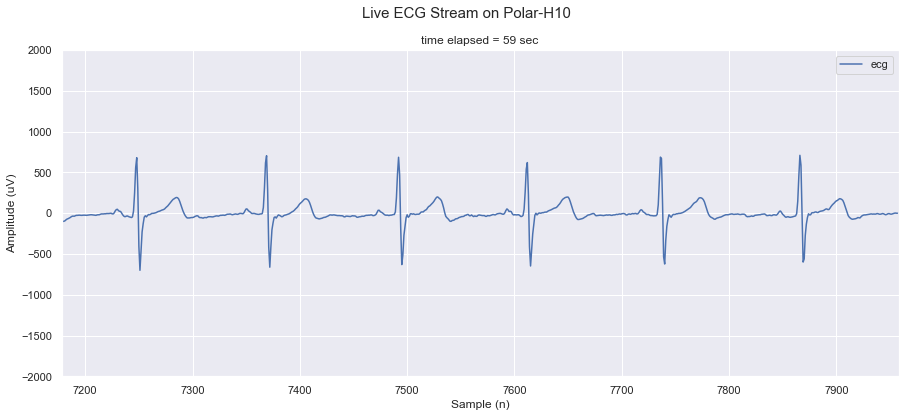

In [6]:
async def main(address):
   
    try:  
        print("[OPEN] application opened...")
        
        client = BleakClient(address)
        await client.connect()
        print('Connection opened.')
        
        model_number = await client.read_gatt_char(MODEL_NBR_UUID)
        print(f'Model Number: {"".join(map(chr, model_number))}')
        
        manufacturer_name = await client.read_gatt_char(MANUFACTURER_NAME_UUID)
        print(f'Manufacturer: {"".join(map(chr, manufacturer_name))}')

        battery_level = await client.read_gatt_char(BATTERY_LEVEL_UUID)
        print(f'Battery Level: {int(battery_level[0])}%')

        att_read = await client.read_gatt_char(PMD_CONTROL)
        if att_read[0] == 0x0F:
            features = att_read[1]
            ECG_SUPPORTED = features&0b000001 != 0
            PPG_SUPPORTED = features&0b000010 != 0
            ACC_SUPPORTED = features&0b000100 != 0
            PPI_SUPPORTED = features&0b001000 != 0
            print('Supported measurement types:') 
            print('    ECG = ', ECG_SUPPORTED)
            print('    PPG = ', PPG_SUPPORTED)
            print('    ACC = ', ACC_SUPPORTED)
            print('    PPI = ', PPI_SUPPORTED) 
            
        ## Start streaming ECG data ##
        await client.write_gatt_char(PMD_CONTROL, ECG_WRITE)

        ## Whenever there is data available, call data_conv
        await client.start_notify(PMD_DATA, ecg_data_conv)

        ## TypicalLY it takes 30 seconds to get the streaming to start
        print(f"Waiting for {WAIT_N_SECONDS} sec...")
        await asyncio.sleep(1)
        time.sleep(WAIT_N_SECONDS)
    
        print("Collecting ECG data...")

        ## Create a graph
        fig = plt.figure(figsize=(15, 6))
        ax1 = fig.add_subplot(1, 1, 1)
        fig.suptitle("Live ECG Stream on Polar-H10", fontsize=15)

        n = ECG_SAMPLING_FREQ

        if len(ecg_data) == 0:
            print('Empty')
        
        while n < REC_LENGTH*ECG_SAMPLING_FREQ:

            ## Collecting ACC data for 1 second
            await asyncio.sleep(1)

            ax1.clear()
            #t = np.arange(len(acc_x_data))/ACC_SAMPLING_FREQ
            ax1.plot(ecg_data, label = 'ecg')
            n0 = len(ecg_data)
            ax1.set_xlim(n0-6*ECG_SAMPLING_FREQ, n0)
            ax1.set_ylim(-2000, +2000)
            ax1.set_ylabel('Amplitude (uV)')
            ax1.set_xlabel('Sample (n)')
            ax1.legend()
            ax1.set_title(f'time elapsed = {n/ECG_SAMPLING_FREQ:.0f} sec')
            display(fig)
            clear_output(wait=True)

            n = n + ECG_SAMPLING_FREQ
               
        ## Stop the stream once data is collected ##
        await client.stop_notify(PMD_DATA)
        print("Stopping ECG data streaming...")
        
        ## Write data to DATAFILE ##
        t = np.arange(len(ecg_data))/ECG_SAMPLING_FREQ
        df = pd.DataFrame({'t': t, 'ecg': ecg_data}, index = None)
        df.to_csv(DATAFILE, index = False, float_format = "%.6f")
        print(f'Data written to file: {DATAFILE}.')
        df.head()    
        
    except Exception as e:
        print(e)
        print(f"Exception: {e=}, {type(e)=}")
        raise
        
    finally:
        await client.disconnect()
        print("[CLOSED] application closed.")

asyncio.run(main(ADDRESS))

## Data check

- Read the data from DATAFILE
- Plot the whole data
- Show the head and tail of the data

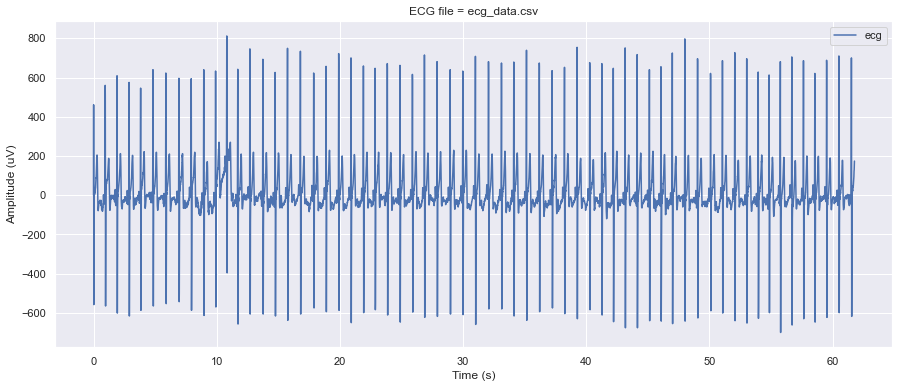

          ecg
t            
0.000000    0
0.007692  461
0.015385  -70
0.023077 -558
0.030769 -541
           ecg
t             
61.738462  125
61.746154  128
61.753846  145
61.761538  161
61.769231  174


In [7]:
df = pd.read_csv(DATAFILE, index_col = 't')
df.plot(figsize = (15, 6));
plt.title(f'ECG file = {DATAFILE}')
plt.ylabel('Amplitude (uV)')
plt.xlabel('Time (s)')
plt.show()
print(df.head())
print(df.tail())